In [2]:
import pandas as pd
import numpy as np

import sys, os, h5py
sys.path.append(os.path.abspath('../../GCN/'))
import gcnIO

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
%matplotlib inline

In [4]:
F = np.load('../../data/pancancer/multiomics_features_raw_fpkm.npy')
with h5py.File('../../data/pancancer/iref_multiomics_norm_gegtexabs_methfcabs_ncglabels.h5', 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None
    if 'feature_names' in f:
        feature_names = f['feature_names'][:]
    else:
        feature_names = None

print (feature_names.shape, features.shape, node_names.shape, F.shape)
#idx = np.array([i for i in range(F.shape[1]) if i < 23 or i > 34])
F_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
F.shape, F_df.shape
#F_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)

(48,) (12129, 48) (12129, 2) (12129, 35)


((12129, 35), (12129, 48))

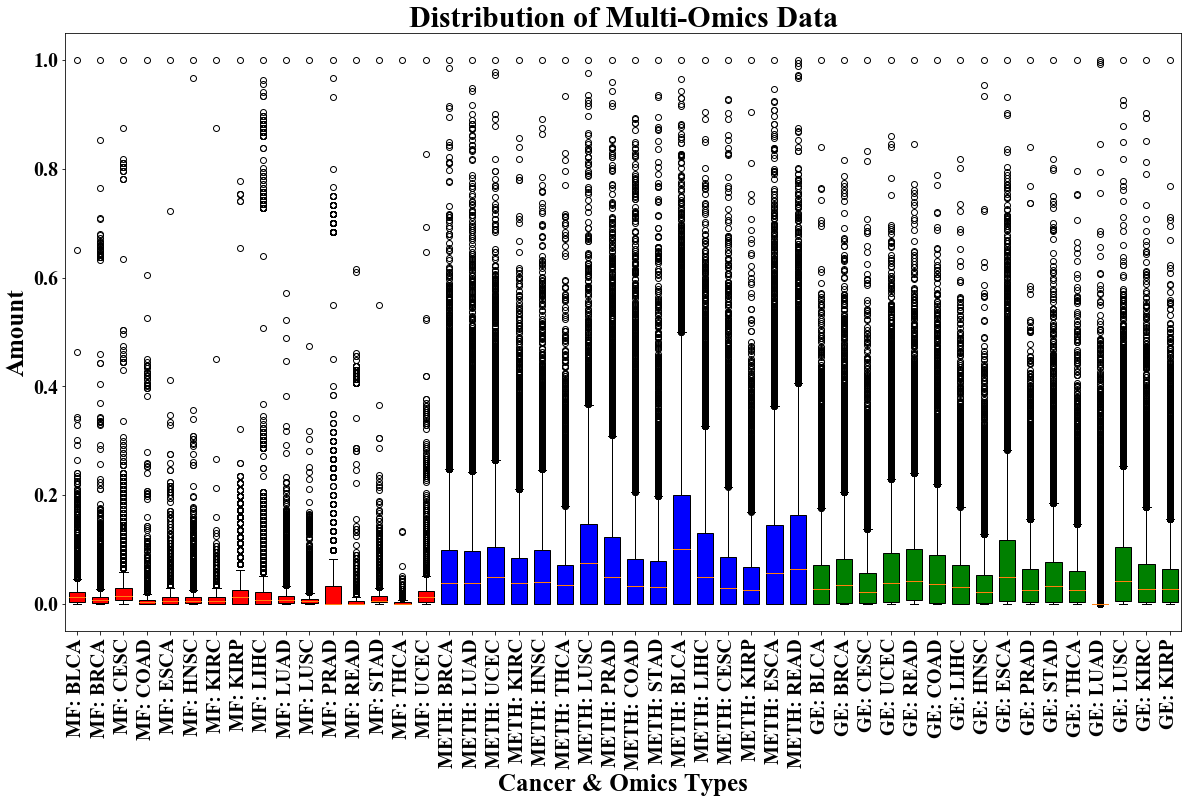

In [8]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# plot
x = plt.boxplot(F_df.values, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, features.shape[1]+1), feature_names, rotation='vertical', fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*16 + ['blue']*16 + ['green']*16
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 1.5])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.title('Distribution of Multi-Omics Data', fontsize=30)
fig.savefig('multiomics_distro_minmax_nogenebodymeth.svg')

In [9]:
F_df_nomutfreq = F_df.iloc[:, 11:]
F_valid = F_df[(F_df_nomutfreq == 0).sum(axis=1) < 3]
F_df.shape, F_valid.shape

((12129, 48), (3316, 48))

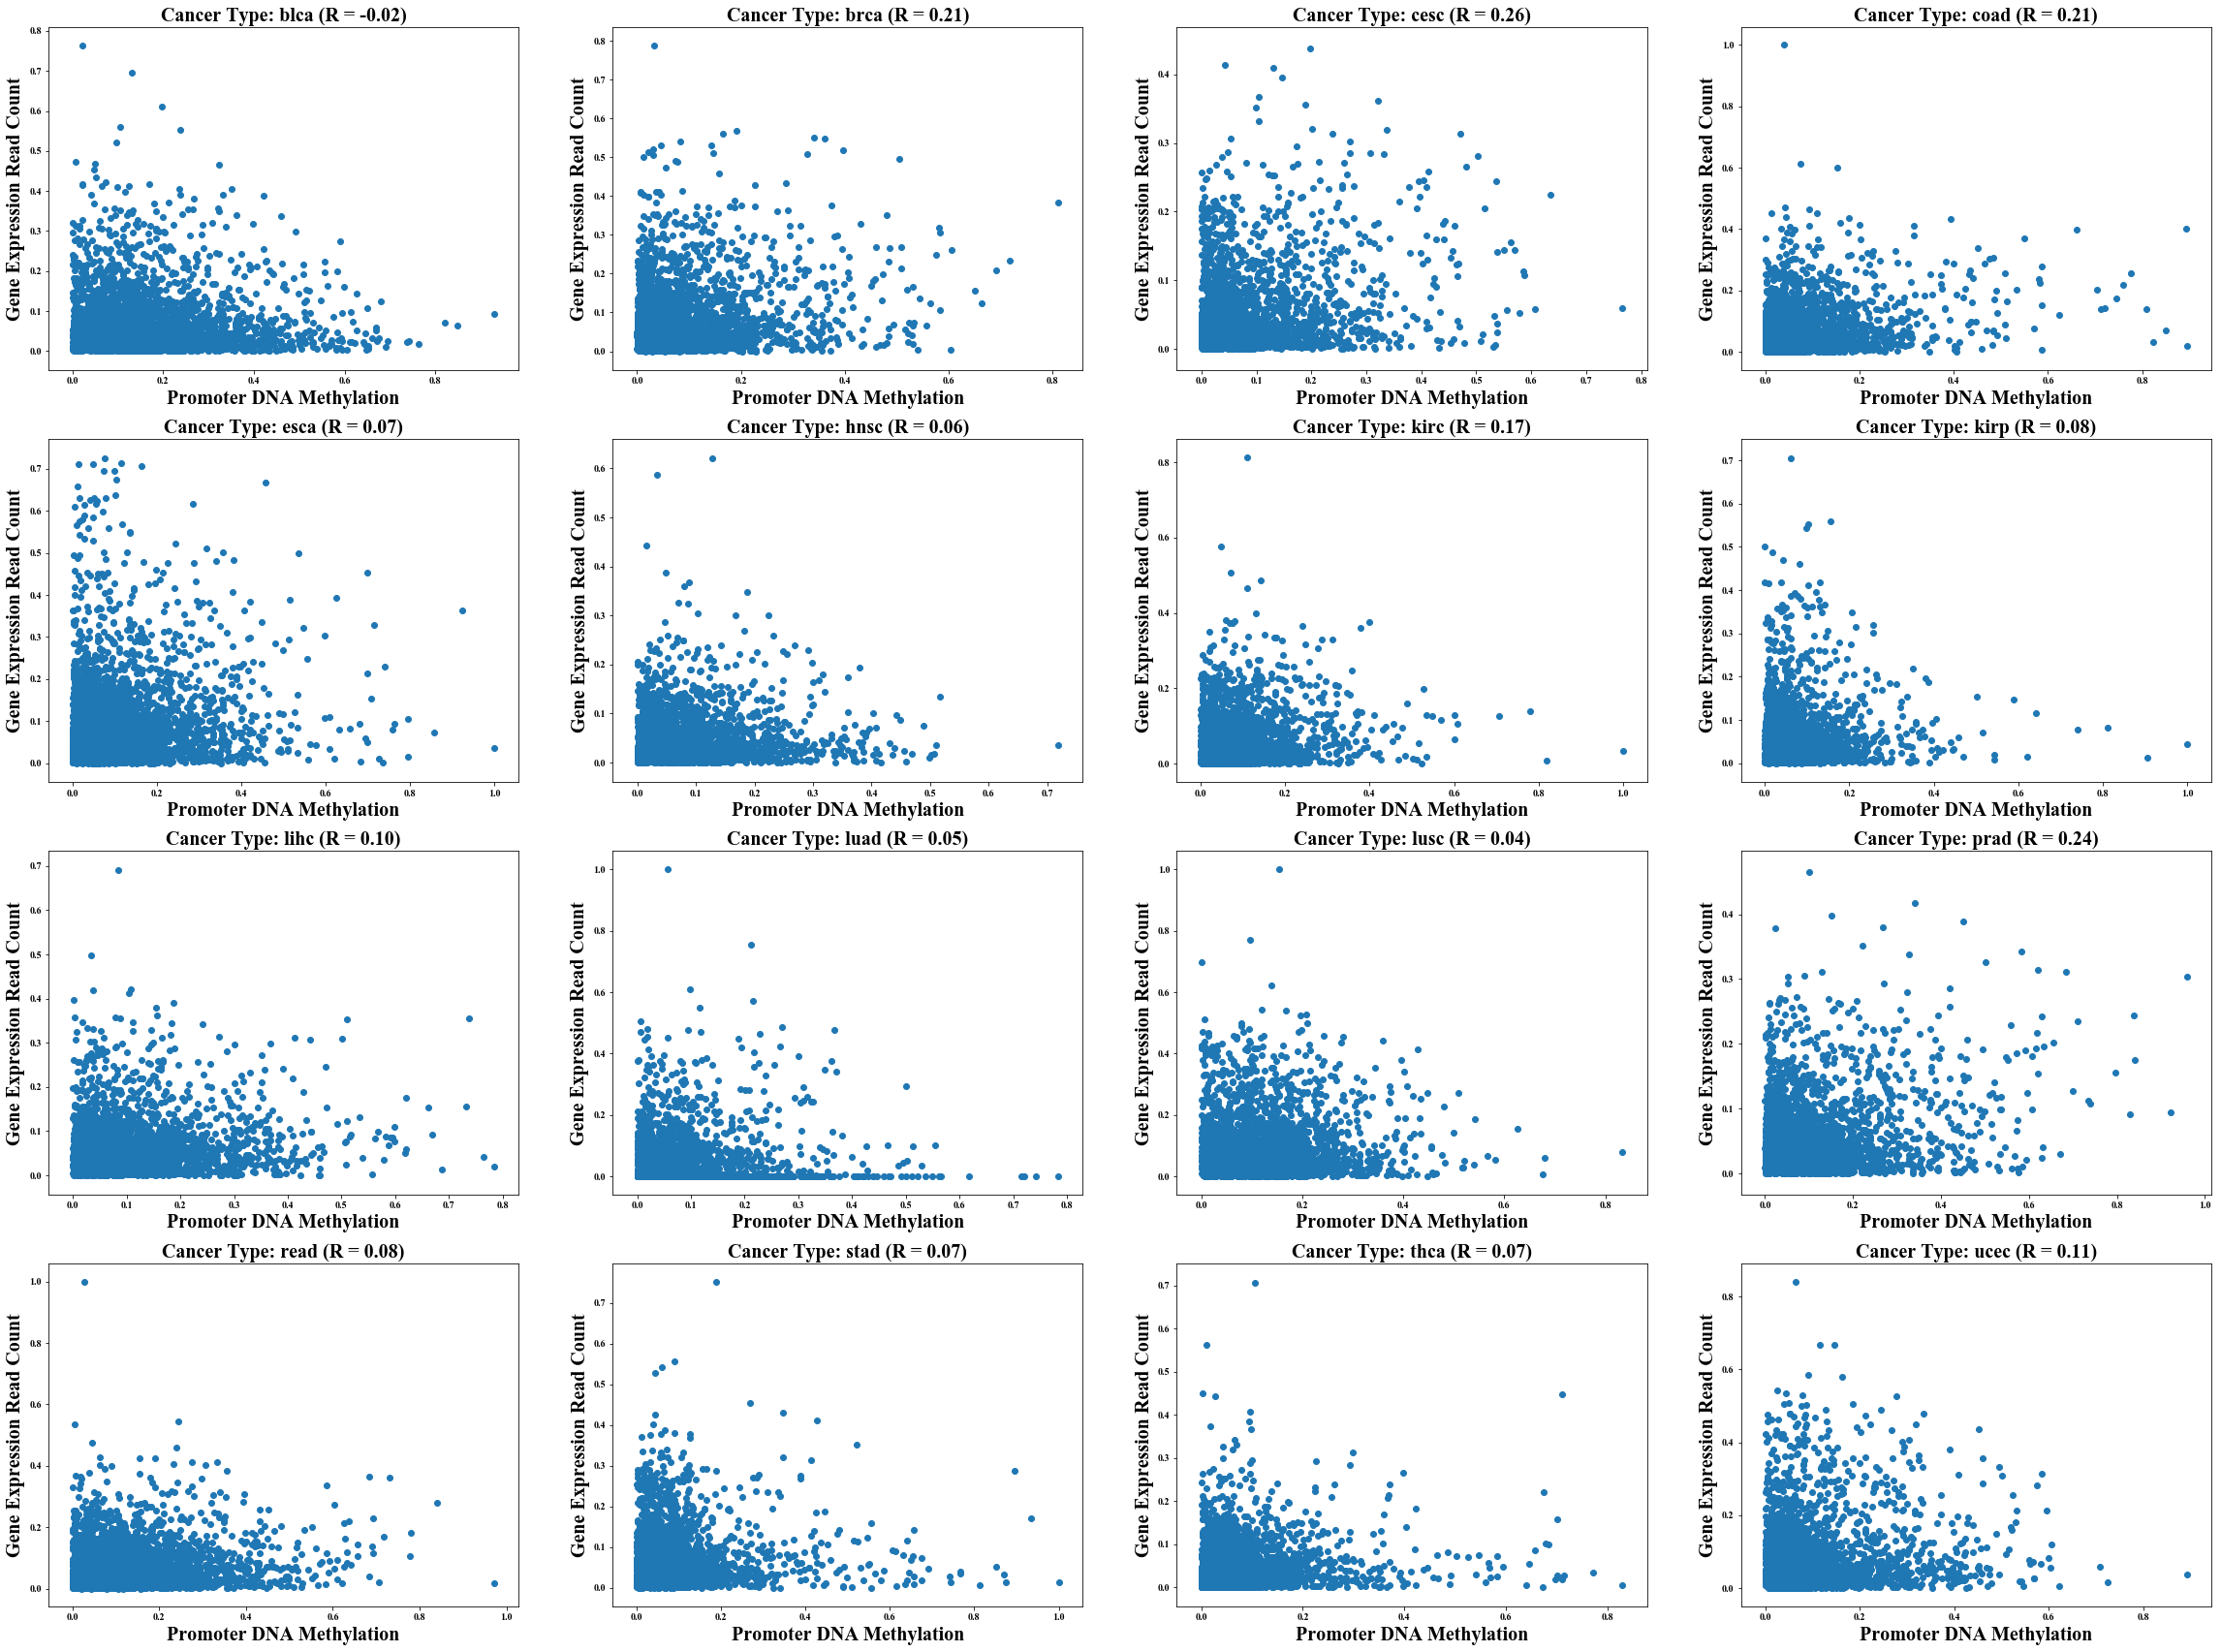

In [12]:
F_valid = F_df[(F_df_nomutfreq == 0).sum(axis=1) < 3]
fig = plt.figure(figsize=(40, 30))
c = 1
for i in ['blca','brca','cesc','coad','esca','hnsc','kirc','kirp','lihc','luad','lusc','prad', 'read', 'stad','thca','ucec']:
    plt.subplot(4, 4, c)
    plt.scatter(F_valid['meth: {}'.format(i).upper()], F_valid['ge: {}'.format(i).upper()])
    corr_coef = F_valid['meth: {}'.format(i).upper()].corr(F_valid['ge: {}'.format(i).upper()])
    plt.title('Cancer Type: {0:} (R = {1:.2f})'.format(i, corr_coef), fontsize=20)
    plt.xlabel('Promoter DNA Methylation', fontsize=20)
    plt.ylabel('Gene Expression Read Count', fontsize=20)
    c += 1
fig.savefig('../../data/pancancer/TCGA/methylation/correlation_ge_meth.png', dpi=300)

In [16]:
cols = [c for c in F_df.columns if not c.startswith('MF')]
F_df[F_df.index.str.startswith('BRCA')][cols]

,METH: BRCA,METH: LUAD,METH: UCEC,METH: KIRC,METH: HNSC,METH: THCA,METH: LUSC,METH: PRAD,METH: COAD,METH: STAD,...,GE: LIHC,GE: HNSC,GE: ESCA,GE: PRAD,GE: STAD,GE: THCA,GE: LUAD,GE: LUSC,GE: KIRC,GE: KIRP
BRCA1,0.050,0.022,0.008,0.003,0.028,0.044,0.122,0.002,0.071,0.023,...,0.065,0.095,0.267,0.007,0.159,0.083,0.129,0.164,0.075,0.066
BRCA2,0.092,0.065,0.102,0.012,0.087,0.085,0.039,0.113,0.034,0.024,...,0.080,0.094,0.366,0.000,0.252,0.042,0.000,0.115,0.000,0.013


In [15]:
cols = [c for c in F_df.columns if c.startswith('METH')]
F_df[cols].idxmax()

METH: BRCA      NKX2-1
METH: LUAD        PAX1
METH: UCEC     ADCYAP1
METH: KIRC       STIM1
METH: HNSC     ADCYAP1
METH: THCA      LGALS1
METH: LUSC       HOXD9
METH: PRAD    APOBEC3C
METH: COAD       RALYL
METH: STAD       NPAS2
METH: BLCA      POU4F2
METH: LIHC       KIF15
METH: CESC     ADCYAP1
METH: KIRP     FAM129B
METH: ESCA       NRCAM
METH: READ      PRDM14
dtype: object